In [ ]:
import argparse
import datetime
import os
import pprint
import yaml

import gym, gym_xarm
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, ReplayBuffer, VectorReplayBuffer, Batch
from tianshou.env import DummyVectorEnv, SubprocVectorEnv
from tianshou.trainer import offpolicy_trainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import ActorProb, Critic
from tianshou.policy import SACPolicy, BasePolicy

import gym_naive
from her_collector import HERCollector

'''
make env
'''
config = {
    'dim': 2,
    'reward_type': 'sparse'
}
def make_env():
    return gym.wrappers.FlattenObservation(gym.make('NaiveReach-v1', config = config))
env = gym.make('NaiveReach-v1', config = config)
observation_space = env.observation_space
env = gym.wrappers.FlattenObservation(env)
obs = (env.reset())
state_shape = len(obs)
action_shape = env.action_space.shape or env.action_space.n
train_envs = SubprocVectorEnv(
    [make_env]*2,
)
test_envs = DummyVectorEnv(
    [make_env],
)

'''
build and init network
'''
# actor
net_a = Net(state_shape, hidden_sizes=[16], device='cpu')
actor = ActorProb(
    net_a,
    action_shape,
    max_action=env.action_space.high[0],
    device='cpu',
    unbounded=True,
    conditioned_sigma=True
).to('cpu')
actor_optim = torch.optim.Adam(actor.parameters(), lr=0.001)
# critic
net_c1 = Net(
    state_shape,
    action_shape,
    hidden_sizes=[16],
    concat=True,
    device='cpu'
)
net_c2 = Net(
    state_shape,
    action_shape,
    hidden_sizes=[16],
    concat=True,
    device='cpu'
)
critic1 = Critic(net_c1, device='cpu').to('cpu')
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=0.001)
critic2 = Critic(net_c2, device='cpu').to('cpu')
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=0.001)

'''
set up policy
'''
policy = SACPolicy(
    actor,
    actor_optim,
    critic1,
    critic1_optim,
    critic2,
    critic2_optim,
    tau=0.005,
    gamma=0.9,
    alpha=0.2,
    estimation_step=2,
    action_space=env.action_space,
    reward_normalization = False
)

'''
set up collector
'''
train_buffer = VectorReplayBuffer(128, 2)
test_buffer = ReplayBuffer(32)
train_collector = HERCollector(policy, train_envs, train_buffer, exploration_noise=True, observation_space = observation_space, reward_fn = env.compute_reward, k = 2)
test_collector = Collector(policy, test_envs, test_buffer, exploration_noise=True)

In [ ]:
'''
trainer
'''
# train_collector.collect(n_step=10, random=True)
# trainer
result = offpolicy_trainer(
    policy,
    train_collector,
    test_collector,
    1,
    100,
    10,
    1,
    4
)

[reward, done] 0.0 False
[reward, done] 0.0 False


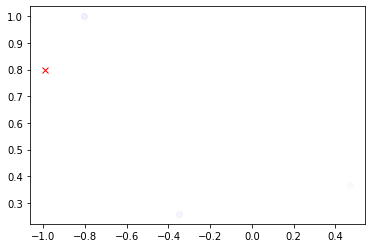

[reward, done] 1.0 True
[reward, done] 0.0 False
[reward, done] 0.0 False
[reward, done] 0.0 False
[reward, done] 0.0 False
[reward, done] 0.0 False
[reward, done] 0.0 False


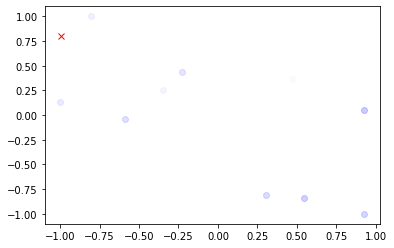

[reward, done] 0.0 True


In [4]:
import gym
from gym import spaces
import numpy as np
import logging
from gym.envs.registration import register
import matplotlib.pyplot as plt
from matplotlib import animation
import time

from numpy.core import einsumfunc

class NaiveReach(gym.GoalEnv):
    def __init__(self, config):
        self.dim = config['dim']
        self.reward_type = config['reward_type']
        self._max_episode_steps = 10
        self.err = 0.3
        self.space = spaces.Box(low=-np.ones(self.dim), high=np.ones(self.dim))
        self.action_space = spaces.Box(low=-np.ones(self.dim), high=np.ones(self.dim))
        self.observation_space = spaces.Dict(dict( # Make sure the observation dict order matchs obs!
            observation=spaces.Box(low=np.array([-300]), high=np.array([-100])),
            achieved_goal=spaces.Box(low=-np.ones(self.dim), high=np.ones(self.dim)),
            desired_goal=spaces.Box(low=-np.ones(self.dim), high=np.ones(self.dim)),
        ))
        self.reset()

    def step(self, action):
        self.num_step += 1
        action = np.clip(action, self.action_space.low, self.action_space.high)
        self.pos = np.clip(self.pos + action, self.space.low, self.space.high)
        obs = {
            'observation': [-250],
            'achieved_goal': self.pos,
            'desired_goal': self.goal
        }
        d = np.linalg.norm(self.pos - self.goal)
        if self.reward_type == 'dense':
            reward = -d
        elif self.reward_type == 'sparse':
            reward = (d<self.err).astype(np.float32)
        elif self.reward_type == 'dense_diff':
            reward = self.d_old - d
            self.d_old = d
        info = {
            'is_success': (d < self.err),
        }
        done = (self.num_step >= self._max_episode_steps) or (d < self.err)
        return obs, reward, done, info

    def reset(self):
        self.num_step = 0
        self.goal = self.space.sample()
        self.pos = self.space.sample()
        self.d_old = np.linalg.norm(self.pos - self.goal)
        obs = {
            'observation': [-250],
            'achieved_goal': self.pos,
            'desired_goal': self.goal
        }
        return obs

    def render(self):
        if self.num_step == 1:
            self.data = [self.pos]
        self.data.append(self.pos)
        if self.num_step == self._max_episode_steps or (np.linalg.norm(self.pos - self.goal))<self.err:
            if self.dim == 2:
                for i,d in enumerate(self.data):
                    plt.plot(d[0], d[1], 'o', color = [0,0,1,i/50])
                plt.plot(self.goal[0], self.goal[1], 'rx')
                plt.show()
            elif self.dim == 3:
                fig = plt.figure()
                ax = fig.add_subplot(projection='3d')
                for i,d in enumerate(self.data):
                    ax.scatter(d[0], d[1], d[2], 'o', color = [0,0,1,i/50])
                plt.show()
            '''
            fig = plt.figure()
            ax = fig.add_subplot()
            point, = ax.plot([self.x[0]], [self.y[0]], 'o')
            def update_point(n, x, y, point):
                point.set_data(np.array([self.x[n], self.y[n]]))
                return point
            ani=animation.FuncAnimation(fig, func = update_point, frames = 49, interval = 1/30, fargs=(self.x, self.y, point))
            '''

    def compute_reward(self, achieved_goal, desired_goal, info):
        d = np.linalg.norm(achieved_goal-desired_goal)
        reward = (d<self.err).astype(np.float32)
        return reward

    def ezpolicy(self, obs):
        return obs[self.dim:] - obs[:self.dim]

# register(
#     id='NaiveReach-v1',
#     entry_point='gym_naive.naive_reach:NaiveReach',
# )

if __name__ == '__main__':
    config = {
        'dim': 2,
        'reward_type': 'sparse'
    }
    env = NaiveReach(config = config)
    obs = env.reset()
    for i in range(10):
        act = env.action_space.sample()
        obs, reward, done, info = env.step(act)
        env.render()
        print('[reward, done]', reward, done)

In [17]:
def fn(x):
    return x+10
ls = [(lambda:fn(x)) for x in range(3)]
for i in range(3): print(ls[i]()) 

12
12
12
